# Initial Data View

In [19]:
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

df['target'] = wine.target
df = df[df['target'] < 2]


In [20]:
print(df)

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols   
0      14.23        1.71  2.43               15.6      127.0           2.80  \
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
125    12.07        2.16  2.17               21.0       85.0           2.60   
126    12.43        1.53  2.29               21.5       86.0           2.74   
127    11.79        2.13  2.78               28.5       92.0           2.13   
128    12.37        1.63  2.30               24.5       88.0           2.22   
129    12.04        4.30  2.38               22.0       80.0           2.10   

     flavanoids  nonflavanoid_phenols  proanthocyan

In [21]:
from sklearn.model_selection import train_test_split
# Prepare features and labels
X = df.drop(columns=['target'])
y = df['target']


# Split the data into train and test sets (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train logistic regression model
model = LogisticRegression(penalty='l2', solver='saga')
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)

print("Accuracy:", accuracy)

Accuracy: 0.9615384615384616


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.linear_model import LinearRegression

# ---------------------------
# 1. Load and preprocess data
# ---------------------------
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

df['target'] = wine.target
# Restrict to classes 0 and 1
df = df[df['target'] < 2]

X = df[wine.feature_names].values   # Shape: (N, d)
y = df['target'].values            # Shape: (N,)

# ---------------------------
# 2. Normalize data so that each feature is in [-1, 1]
#    X_norm[j] = 2 * (X[j] - min(X[j])) / (max(X[j]) - min(X[j])) - 1
# ---------------------------
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_range = X_max - X_min

# Safeguard against division by zero: if a feature is constant, keep it at 0
X_range[X_range == 0] = 1e-9

X_norm = 2.0 * (X - X_min) / X_range - 1.0

# ---------------------------
# 3. Initialize weights using a simple line of best fit (LinearRegression)
#    We'll do a linear regression on X_norm -> y, then store intercept + coefs.
# ---------------------------
linreg = LinearRegression()
linreg.fit(X_norm, y)

# Extract coefficients and intercept
# w_init will include intercept as w[0], followed by coefficients
w_init = np.concatenate(([linreg.intercept_], linreg.coef_))

# Augment X with a column of ones so that we can treat the intercept
# as just another weight dimension.
# New shape of X_aug: (N, d+1)
X_aug = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

# ---------------------------
# 4. Define helper functions
# ---------------------------
def sigmoid(z):
    """
    The logistic sigmoid function.
    """
    return 1 / (1 + np.exp(-z))

def logistic_loss(X_aug, y, w):
    """
    Computes the average negative log-likelihood (logistic loss).
    """
    eps = 1e-10  # For numerical stability
    predictions = sigmoid(X_aug @ w)  # Shape: (N,)
    N = X_aug.shape[0]
    loss_val = -1.0 / N * np.sum(
        y * np.log(predictions + eps) + (1 - y) * np.log(1 - predictions + eps)
    )
    return loss_val

def compute_gradient(X_aug, y, w):
    """
    Computes the gradient of the negative log-likelihood (logistic loss).
    X_aug: (N, d+1) with the first column all ones (for intercept).
    y:     (N,) binary labels in {0, 1}.
    w:     (d+1,) current weight vector (including intercept).
    
    Returns:
       grad: (d+1,) gradient of logistic loss w.r.t. w
    """
    N = X_aug.shape[0]
    predictions = sigmoid(X_aug @ w)      # Shape: (N,)
    grad = (1.0 / N) * (X_aug.T @ (predictions - y))
    return grad

def get_largest_gradient_dimension(X_aug, y, w):
    """
    1. Compute the gradient for the current parameter w.
    2. Find the index of the dimension with largest absolute partial derivative.
    
    Returns:
       grad: the gradient (d+1,)
       idx:  index of the largest (by absolute value) partial derivative
    """
    grad = compute_gradient(X_aug, y, w)
    idx = np.argmax(np.abs(grad))
    return grad, idx

def coordinate_descent_update(X_aug, y, w, idx, step_size, grad, num_steps=10):
    """
    Performs repeated updates on a single coordinate (dimension) 'idx' with a fixed
    step size. We re-compute the gradient each step because as we update w[idx],
    the partial derivative changes.
    
    After each update, print the current loss.
    
    X_aug: (N, d+1) data
    y:     (N,)     labels
    w:     (d+1,)   weights (updated in place)
    idx:   int      which dimension to update
    step_size: float
    num_steps: int   how many small updates to perform in that coordinate
    """
    current_loss = logistic_loss(X_aug, y, w)
    print(f"[Coordinate {idx}, Pre-Update Loss = {current_loss:.4f}")
    for step in range(num_steps):
        # Re-compute gradient
        
        
        # Perform coordinate descent update in the negative gradient direction
        w[idx] -= step_size * grad[idx]
        
        # Print loss after each update
        new_loss = logistic_loss(X_aug, y, w)

        if new_loss > current_loss:
            w[idx] += grad[idx] * step_size
            print(f"Stopped Early after {step} steps")
            break
        else:
            current_loss = new_loss
        
    print(f"[Coordinate {idx}, Post-Update Loss = {current_loss:.4f}")

# ---------------------------
# 5. Run the procedure
# ---------------------------

# Copy initial weights (so we don't overwrite w_init)
w = w_init.copy()

print("Initial loss:", logistic_loss(X_aug, y, w))

# Choose a fixed step size
step_size = 0.01

# Number of outer iterations over coordinates
num_outer_iters = 100

for iteration in range(num_outer_iters):
    print(f"\n--- Outer Iteration {iteration+1}/{num_outer_iters} ---")
    # 1. Find the coordinate with largest partial derivative
    grad, idx = get_largest_gradient_dimension(X_aug, y, w)
    
    # 2. Update that coordinate repeatedly
    coordinate_descent_update(X_aug, y, w, idx, step_size, grad, num_steps=50)

print("Final loss:", logistic_loss(X_aug, y, w))


Initial loss: 0.5158783355150558

--- Outer Iteration 1/100 ---
[Coordinate 1, Pre-Update Loss = 0.5159
[Coordinate 1, Post-Update Loss = 0.5051

--- Outer Iteration 2/100 ---
[Coordinate 1, Pre-Update Loss = 0.5051
[Coordinate 1, Post-Update Loss = 0.4948

--- Outer Iteration 3/100 ---
[Coordinate 1, Pre-Update Loss = 0.4948
[Coordinate 1, Post-Update Loss = 0.4850

--- Outer Iteration 4/100 ---
[Coordinate 1, Pre-Update Loss = 0.4850
[Coordinate 1, Post-Update Loss = 0.4757

--- Outer Iteration 5/100 ---
[Coordinate 1, Pre-Update Loss = 0.4757
[Coordinate 1, Post-Update Loss = 0.4667

--- Outer Iteration 6/100 ---
[Coordinate 1, Pre-Update Loss = 0.4667
[Coordinate 1, Post-Update Loss = 0.4582

--- Outer Iteration 7/100 ---
[Coordinate 1, Pre-Update Loss = 0.4582
[Coordinate 1, Post-Update Loss = 0.4501

--- Outer Iteration 8/100 ---
[Coordinate 1, Pre-Update Loss = 0.4501
[Coordinate 1, Post-Update Loss = 0.4424

--- Outer Iteration 9/100 ---
[Coordinate 1, Pre-Update Loss = 0.4424


## My Method: Full implementation

In [23]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.linear_model import LinearRegression

# ---------------------------
# 1. Load and preprocess data
# ---------------------------
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

df['target'] = wine.target
# Restrict to classes 0 and 1
df = df[df['target'] < 2]

X = df[wine.feature_names].values   # Shape: (N, d)
y = df['target'].values            # Shape: (N,)

# ---------------------------
# 2. Normalize each feature to be in [-1, 1]
#    X_norm[j] = 2 * (X[j] - min(X[j])) / (max(X[j]) - min(X[j])) - 1
# ---------------------------
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_range = X_max - X_min

# Safeguard: If a feature is constant, replace zero range by small value
X_range[X_range == 0] = 1e-9

X_norm = 2.0 * (X - X_min) / X_range - 1.0

# ---------------------------
# 3. Initialize weights using a simple line of best fit (LinearRegression)
#    We'll fit linear regression on X_norm -> y, then extract intercept + coefs.
# ---------------------------
linreg = LinearRegression()
linreg.fit(X_norm, y)

# w_init will include intercept as w[0], followed by coefficients
w_init = np.concatenate(([linreg.intercept_], linreg.coef_))

# Augment X with a column of ones (for the intercept),
# so X_aug has shape (N, d+1).
X_aug = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

# ---------------------------
# 4. Define helper functions
# ---------------------------
def sigmoid(z):
    """
    Logistic sigmoid function.
    """
    return 1 / (1 + np.exp(-z))

def logistic_loss(X_aug, y, w):
    """
    Computes the average negative log-likelihood (logistic loss).
    """
    eps = 1e-10  # For numerical stability
    predictions = sigmoid(X_aug @ w)  # Shape: (N,)
    N = X_aug.shape[0]
    loss_val = -1.0 / N * np.sum(
        y * np.log(predictions + eps) + (1 - y) * np.log(1 - predictions + eps)
    )
    return loss_val

def find_best_coordinate_and_direction(X_aug, y, w, step_size):
    """
    For each coordinate i, we try moving w[i] + step_size and w[i] - step_size.
    We see how much each move decreases the logistic loss.

    We pick the coordinate and direction (+/-) that yields the greatest
    DECREASE in the loss.

    Returns:
      best_coord:    The index (0..d) that yields the largest improvement
      best_direction: +1 or -1, indicating which direction is best
      best_improvement: The amount of loss decrease achieved by that coordinate/direction
    """
    current_loss = logistic_loss(X_aug, y, w)
    best_coord = 0
    best_direction = 0
    best_improvement = 0.0

    d_plus_one = len(w)

    for i in range(d_plus_one):
        # Try w[i] + step_size
        w_temp_plus = w.copy()
        w_temp_plus[i] += step_size
        loss_plus = logistic_loss(X_aug, y, w_temp_plus)
        improvement_plus = current_loss - loss_plus  # positive if the loss went down

        # Try w[i] - step_size
        w_temp_minus = w.copy()
        w_temp_minus[i] -= step_size
        loss_minus = logistic_loss(X_aug, y, w_temp_minus)
        improvement_minus = current_loss - loss_minus

        # Determine which direction yields the larger improvement for this coordinate
        if improvement_plus > improvement_minus:
            improvement_for_i = improvement_plus
            direction_for_i = +1
        else:
            improvement_for_i = improvement_minus
            direction_for_i = -1

        # Check if this is better than our current best
        if improvement_for_i > best_improvement:
            best_improvement = improvement_for_i
            best_coord = i
            best_direction = direction_for_i

    return best_coord, best_direction, best_improvement

def coordinate_descent_update(X_aug, y, w, coord, direction, step_size, num_steps=5):
    """
    Once we've chosen which coordinate and direction yields the best
    immediate improvement, we can do multiple steps in that direction.

    For each step, we update w[coord] by 'direction * step_size'
    and print the new loss.
    """
    curr_loss = logistic_loss(X_aug, y, w)
    print(f"Pre-Update Loss = {curr_loss:.4f}")
    
    for step in range(num_steps):
        
        w[coord] += direction * step_size
        new_loss = logistic_loss(X_aug, y, w)
        if new_loss > curr_loss:
            w[coord] -= direction * step_size
            print(f"Stopped Early after {step} steps")
            break
        else:
            curr_loss = new_loss
    print(f"Post-Update Loss = {logistic_loss(X_aug, y, w):.4f}")
        

# ---------------------------
# 5. Run the procedure
# ---------------------------
w = w_init.copy()
initial_loss = logistic_loss(X_aug, y, w)

print(f"Initial Loss: {initial_loss:.4f}")

num_outer_iters = 100  # Number of times we scan and pick the best coordinate
step_size = 0.01      # Fixed step size
num_steps = 50        # How many times we move in that chosen direction once found

for iteration in range(num_outer_iters):
    print(f"\n--- Outer Iteration {iteration+1}/{num_outer_iters} ---")
    best_coord, best_direction, best_improvement = find_best_coordinate_and_direction(X_aug, y, w, step_size)

    if best_improvement <= 0:
        # No improvement found by any coordinate update (could happen if we're at a local minimum or step is too large)
        print("No further improvement found. Stopping early.")
        break

    # Otherwise, do multiple steps in that chosen coordinate and direction
    print(f"Best coordinate: {best_coord}, direction: {best_direction}, improvement: {best_improvement:.4f}")
    coordinate_descent_update(X_aug, y, w, best_coord, best_direction, step_size, num_steps=num_steps)

# Final result
final_loss = logistic_loss(X_aug, y, w)
print("\nFinal weights (including intercept):", w)
print(f"Final Loss: {final_loss:.4f}")


Initial Loss: 0.5159

--- Outer Iteration 1/100 ---
Best coordinate: 1, direction: -1, improvement: 0.0015
Pre-Update Loss = 0.5159
Post-Update Loss = 0.4479

--- Outer Iteration 2/100 ---
Best coordinate: 1, direction: -1, improvement: 0.0012
Pre-Update Loss = 0.4479
Post-Update Loss = 0.3910

--- Outer Iteration 3/100 ---
Best coordinate: 13, direction: -1, improvement: 0.0011
Pre-Update Loss = 0.3910
Post-Update Loss = 0.3439

--- Outer Iteration 4/100 ---
Best coordinate: 1, direction: -1, improvement: 0.0009
Pre-Update Loss = 0.3439
Post-Update Loss = 0.3028

--- Outer Iteration 5/100 ---
Best coordinate: 1, direction: -1, improvement: 0.0007
Pre-Update Loss = 0.3028
Post-Update Loss = 0.2693

--- Outer Iteration 6/100 ---
Best coordinate: 0, direction: -1, improvement: 0.0006
Pre-Update Loss = 0.2693
Stopped Early after 42 steps
Post-Update Loss = 0.2558

--- Outer Iteration 7/100 ---
Best coordinate: 13, direction: -1, improvement: 0.0008
Pre-Update Loss = 0.2558
Post-Update Los

## Code for Comparison Between Methods


=== Method 1: Best Coordinate Descent ===
Initial Loss (Method 1): 0.5159

--- Outer Iteration 1/100 (Method 1) ---
Best coordinate: 1, direction: -1, improvement: 0.0015
   Pre-Update Loss = 0.5159
   Post-Update Loss = 0.4479

--- Outer Iteration 2/100 (Method 1) ---
Best coordinate: 1, direction: -1, improvement: 0.0012
   Pre-Update Loss = 0.4479
   Post-Update Loss = 0.3910

--- Outer Iteration 3/100 (Method 1) ---
Best coordinate: 13, direction: -1, improvement: 0.0011
   Pre-Update Loss = 0.3910
   Post-Update Loss = 0.3439

--- Outer Iteration 4/100 (Method 1) ---
Best coordinate: 1, direction: -1, improvement: 0.0009
   Pre-Update Loss = 0.3439
   Post-Update Loss = 0.3028

--- Outer Iteration 5/100 (Method 1) ---
Best coordinate: 1, direction: -1, improvement: 0.0007
   Pre-Update Loss = 0.3028
   Post-Update Loss = 0.2693

--- Outer Iteration 6/100 (Method 1) ---
Best coordinate: 0, direction: -1, improvement: 0.0006
   Pre-Update Loss = 0.2693
   Stopped Early after 42 ste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

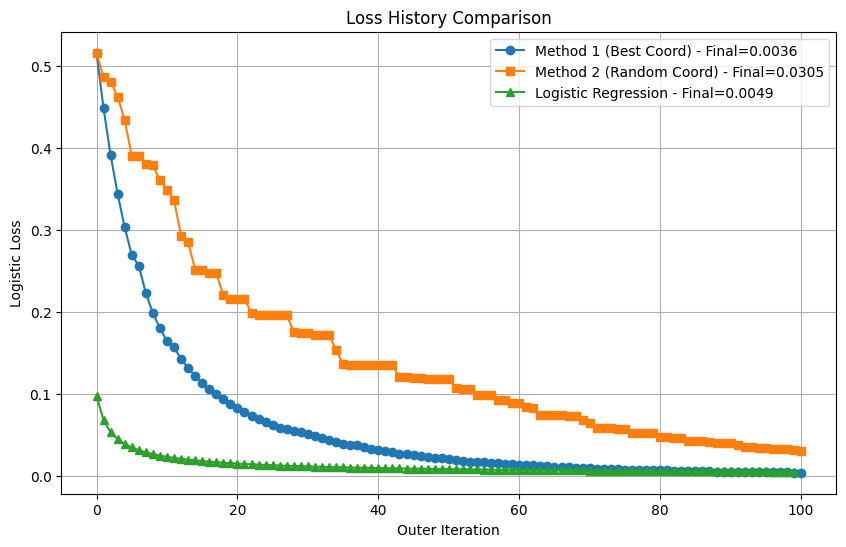

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.linear_model import LinearRegression, LogisticRegression

# ---------------------------
# 1. Load and preprocess data
# ---------------------------
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
# Restrict to classes 0 and 1
df = df[df['target'] < 2]

X = df[wine.feature_names].values  # Shape: (N, d)
y = df['target'].values            # Shape: (N,)

# ---------------------------
# 2. Normalize each feature to be in [-1, 1]
# ---------------------------
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_range = X_max - X_min
X_range[X_range == 0] = 1e-9  # safeguard against division by zero
X_norm = 2.0 * (X - X_min) / X_range - 1.0

# ---------------------------
# 3. Initialize weights via linear regression
# ---------------------------
linreg = LinearRegression()
linreg.fit(X_norm, y)
# w_init: intercept + coefficients
w_init = np.concatenate(([linreg.intercept_], linreg.coef_))
X_aug = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

# ---------------------------
# 4. Helper functions
# ---------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(X_aug, y, w):
    eps = 1e-10
    preds = sigmoid(X_aug @ w)
    return -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))

def find_best_coordinate_and_direction(X_aug, y, w, step_size):
    current_loss = logistic_loss(X_aug, y, w)
    best_coord, best_direction, best_improvement = 0, 0, 0.0
    for i in range(len(w)):
        w_temp_plus = w.copy()
        w_temp_plus[i] += step_size
        plus_loss = logistic_loss(X_aug, y, w_temp_plus)
        improvement_plus = current_loss - plus_loss

        w_temp_minus = w.copy()
        w_temp_minus[i] -= step_size
        minus_loss = logistic_loss(X_aug, y, w_temp_minus)
        improvement_minus = current_loss - minus_loss

        if improvement_plus > improvement_minus:
            improvement_for_i = improvement_plus
            direction_for_i = +1
        else:
            improvement_for_i = improvement_minus
            direction_for_i = -1

        if improvement_for_i > best_improvement:
            best_improvement = improvement_for_i
            best_coord = i
            best_direction = direction_for_i
    return best_coord, best_direction, best_improvement

def pick_random_coordinate_and_direction(X_aug, y, w, step_size):
    current_loss = logistic_loss(X_aug, y, w)
    coord = np.random.randint(0, len(w))
    
    w_temp_plus = w.copy()
    w_temp_plus[coord] += step_size
    plus_loss = logistic_loss(X_aug, y, w_temp_plus)
    improvement_plus = current_loss - plus_loss

    w_temp_minus = w.copy()
    w_temp_minus[coord] -= step_size
    minus_loss = logistic_loss(X_aug, y, w_temp_minus)
    improvement_minus = current_loss - minus_loss

    if improvement_plus > improvement_minus:
        best_direction = +1
        best_improvement = improvement_plus
    else:
        best_direction = -1
        best_improvement = improvement_minus
    return coord, best_direction, best_improvement

def coordinate_descent_update(X_aug, y, w, coord, direction, step_size, num_steps=5):
    curr_loss = logistic_loss(X_aug, y, w)
    print(f"   Pre-Update Loss = {curr_loss:.4f}")
    for step in range(num_steps):
        w[coord] += direction * step_size
        new_loss = logistic_loss(X_aug, y, w)
        if new_loss > curr_loss:
            w[coord] -= direction * step_size
            print(f"   Stopped Early after {step} steps (no improvement).")
            break
        else:
            curr_loss = new_loss
    print(f"   Post-Update Loss = {logistic_loss(X_aug, y, w):.4f}")

# ---------------------------
# 5. Fixed parameters
# ---------------------------
num_outer_iters = 100
step_size = 0.01
num_steps = 50

# Record histories
method1_loss_history = []
method2_loss_history = []
logreg_loss_history = []

# ---------------------------
# 6. Method 1: Best Coordinate Descent
# ---------------------------
print("\n=== Method 1: Best Coordinate Descent ===")
w_method1 = w_init.copy()
initial_loss_method1 = logistic_loss(X_aug, y, w_method1)
print(f"Initial Loss (Method 1): {initial_loss_method1:.4f}")
method1_loss_history.append(initial_loss_method1)

for iteration in range(num_outer_iters):
    print(f"\n--- Outer Iteration {iteration+1}/{num_outer_iters} (Method 1) ---")
    best_coord, best_direction, best_improvement = find_best_coordinate_and_direction(X_aug, y, w_method1, step_size)
    if best_improvement <= 0:
        print("No further improvement found. Stopping early.")
        break
    print(f"Best coordinate: {best_coord}, direction: {best_direction}, improvement: {best_improvement:.4f}")
    coordinate_descent_update(X_aug, y, w_method1, best_coord, best_direction, step_size, num_steps=num_steps)
    current_loss = logistic_loss(X_aug, y, w_method1)
    method1_loss_history.append(current_loss)
final_loss_method1 = logistic_loss(X_aug, y, w_method1)
print("\nFinal weights (Method 1):", w_method1)
print(f"Final Loss (Method 1): {final_loss_method1:.4f}")

# ---------------------------
# 7. Method 2: Random Coordinate Descent
# ---------------------------
print("\n=== Method 2: Random Coordinate Descent ===")
w_method2 = w_init.copy()
initial_loss_method2 = logistic_loss(X_aug, y, w_method2)
print(f"Initial Loss (Method 2): {initial_loss_method2:.4f}")
method2_loss_history.append(initial_loss_method2)

for iteration in range(num_outer_iters):
    print(f"\n--- Outer Iteration {iteration+1}/{num_outer_iters} (Method 2) ---")
    coord, direction, improvement = pick_random_coordinate_and_direction(X_aug, y, w_method2, step_size)
    if improvement <= 0:
        print(f"Coordinate {coord} yields no improvement in either direction. No update performed.")
    else:
        print(f"Random coordinate: {coord}, direction: {direction}, improvement: {improvement:.6f}")
        coordinate_descent_update(X_aug, y, w_method2, coord, direction, step_size, num_steps=num_steps)
    current_loss = logistic_loss(X_aug, y, w_method2)
    method2_loss_history.append(current_loss)
final_loss_method2 = logistic_loss(X_aug, y, w_method2)
print("\nFinal weights (Method 2):", w_method2)
print(f"Final Loss (Method 2): {final_loss_method2:.4f}")

# ---------------------------
# 8. Logistic Regression (Warm Start) for same # of iters
# ---------------------------
print("\n=== Logistic Regression (No Regularization, Warm Start) ===")
logreg = LogisticRegression(penalty=None, solver='saga', warm_start=True, max_iter=1, random_state=42)
for iteration in range(num_outer_iters):
    logreg.fit(X_norm, y)
    w_logreg = np.concatenate(([logreg.intercept_[0]], logreg.coef_[0]))
    current_logreg_loss = logistic_loss(X_aug, y, w_logreg)
    logreg_loss_history.append(current_logreg_loss)
    print(f"Iteration {iteration+1}/{num_outer_iters} Logistic Regression Loss: {current_logreg_loss:.4f}")
final_logreg_loss = logreg_loss_history[-1]
print(f"\nFinal Loss from Logistic Regression: {final_logreg_loss:.4f}")

print("\n\n=====================Final Losses=====================")
print(f"Final Loss (Method 1): {final_loss_method1:.4f}")
print(f"Final Loss (Method 2): {final_loss_method2:.4f}")
print(f"Final Loss from Logistic Regression: {final_logreg_loss:.4f}")

# ---------------------------
# 9. Plot Loss History Comparison
# ---------------------------
plt.figure(figsize=(10, 6))

# Create labels that contain the final losses:
m1_label = f"Method 1 (Best Coord) - Final={final_loss_method1:.4f}"
m2_label = f"Method 2 (Random Coord) - Final={final_loss_method2:.4f}"
lr_label = f"Logistic Regression - Final={final_logreg_loss:.4f}"

plt.plot(method1_loss_history, label=m1_label, marker='o')
plt.plot(method2_loss_history, label=m2_label, marker='s')
plt.plot(logreg_loss_history, label=lr_label, marker='^')

plt.xlabel('Outer Iteration')
plt.ylabel('Logistic Loss')
plt.title('Loss History Comparison')
plt.legend()
plt.grid(True)
plt.show()


## K-sparse comparison

In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# ===========================
# 1. Load and preprocess data
# ===========================
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
df = df[df['target'] < 2]  # Restrict to binary classes 0 and 1

X = df[wine.feature_names].values
y = df['target'].values

# ===========================
# 2. Normalize to [-1, 1]
# ===========================
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_range = X_max - X_min
X_range[X_range == 0] = 1e-9  # Avoid division by zero
X_norm = 2.0 * (X - X_min) / X_range - 1.0

# For our custom coordinate descent approach, we augment X with a column of 1s for the intercept
n_samples, n_features = X_norm.shape
X_aug = np.hstack([np.ones((n_samples, 1)), X_norm])  # shape: (N, d+1)

# ===========================
# 3. Helper functions
# ===========================
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(X_aug, y, w):
    eps = 1e-10
    preds = sigmoid(X_aug @ w)
    return -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))

def find_best_coordinate_and_direction_k_sparse(X_aug, y, w, step_size, active_dims, k):
    """
    - If len(active_dims) < k, search among all coordinates.
    - Otherwise, only search among active_dims.
    Returns: (best_coord, best_direction, best_improvement).
    Possibly updates active_dims if we discover a new coordinate and we haven't hit k yet.
    """
    current_loss = logistic_loss(X_aug, y, w)
    best_coord = None
    best_direction = 0
    best_improvement = 0.0
    
    # Coordinates to search
    if len(active_dims) < k:
        search_coords = range(len(w))
    else:
        search_coords = active_dims

    for i in search_coords:
        # Try + step
        w_temp_plus = w.copy()
        w_temp_plus[i] += step_size
        plus_loss = logistic_loss(X_aug, y, w_temp_plus)
        improvement_plus = current_loss - plus_loss

        # Try - step
        w_temp_minus = w.copy()
        w_temp_minus[i] -= step_size
        minus_loss = logistic_loss(X_aug, y, w_temp_minus)
        improvement_minus = current_loss - minus_loss

        if improvement_plus > improvement_minus:
            improvement_for_i = improvement_plus
            direction_for_i = +1
        else:
            improvement_for_i = improvement_minus
            direction_for_i = -1

        if improvement_for_i > best_improvement:
            best_improvement = improvement_for_i
            best_coord = i
            best_direction = direction_for_i

    # If we found a coordinate that improves and haven't reached k active dims yet
    if best_coord is not None and len(active_dims) < k:
        if best_coord not in active_dims:
            active_dims.add(best_coord)

    return best_coord, best_direction, best_improvement

def coordinate_descent_update(X_aug, y, w, coord, direction, step_size, num_steps=5):
    curr_loss = logistic_loss(X_aug, y, w)
    for _ in range(num_steps):
        w[coord] += direction * step_size
        new_loss = logistic_loss(X_aug, y, w)
        if new_loss > curr_loss:
            w[coord] -= direction * step_size  # revert
            break
        else:
            curr_loss = new_loss

def run_k_sparse_cd(X_aug, y, k, max_iters=100, step_size=0.01, num_steps=50):
    """
    Runs coordinate descent with a maximum of k active coordinates.
    w is initialized to zeros (including intercept).
    Returns final loss and the final weight vector.
    """
    d_plus_1 = X_aug.shape[1]
    w = np.zeros(d_plus_1, dtype=float)  # intercept + features = all zeros
    active_dims = set()

    for _ in range(max_iters):
        best_coord, best_direction, best_improvement = find_best_coordinate_and_direction_k_sparse(
            X_aug, y, w, step_size, active_dims, k
        )
        if best_coord is None or best_improvement <= 0:
            break
        coordinate_descent_update(X_aug, y, w, best_coord, best_direction, step_size, num_steps)
    
    final_loss = logistic_loss(X_aug, y, w)
    return final_loss, w, active_dims

# ===========================
# 4. Compare for a list of k
# ===========================
k_list = [1, 2, 3, 5, 7, 10]

cd_losses = []   # coordinate descent k-sparse
sk_losses = []   # SelectKBest + LR pipeline

for k in k_list:
    # 4A) k-sparse coordinate descent
    loss_cd, w_cd, active_dims = run_k_sparse_cd(
        X_aug, y, k, max_iters=100, step_size=0.01, num_steps=50
    )
    cd_losses.append(loss_cd)
    
    # 4B) "SelectKBest + LR(penalty='none')"
    pipe = Pipeline([
        ("select", SelectKBest(score_func=f_classif, k=k)),
        ("logreg", LogisticRegression(penalty=None, max_iter=1000))
    ])
    pipe.fit(X_norm, y)
    
    # Evaluate final logistic loss
    preds = pipe.predict_proba(X_norm)[:, 1]
    eps = 1e-10
    loss_sk = -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))
    sk_losses.append(loss_sk)

# ===========================
# 5. Print a Table of Results
# ===========================
print("\\begin{table}[h]")
print("\\centering")
print("\\begin{tabular}{c|cc}")
print("\\hline")
print(" $k$ & CD k-sparse Loss & SelectKBest+LR Loss \\\\")
print("\\hline")
for i, k_val in enumerate(k_list):
    print(f"{k_val} & {cd_losses[i]:.4f} & {sk_losses[i]:.4f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\caption{Comparison of final logistic losses for various $k$.}")
print("\\label{tab:k_sparse_comparison}")
print("\\end{table}")

\begin{table}[h]
\centering
\begin{tabular}{c|cc}
\hline
 $k$ & CD k-sparse Loss & SelectKBest+LR Loss \\
\hline
1 & 0.2782 & 0.1585 \\
2 & 0.0967 & 0.0758 \\
3 & 0.0758 & 0.0394 \\
5 & 0.0376 & 0.0001 \\
7 & 0.0054 & 0.0004 \\
10 & 0.0040 & 0.0007 \\
\hline
\end{tabular}
\caption{Comparison of final logistic losses for various $k$.}
\label{tab:k_sparse_comparison}
\end{table}
